# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import setup_multi_gpus, create_corr_matrix, reduce_memory, resample_df, df_to_lstm_format

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

Using TensorFlow backend.
/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 4


# Load data

In [3]:
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'H', combine_all_dwellings=True)

#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
df['hour'] = df.index.hour #create column containing the hour
df['dayofweek'] = df.index.dayofweek
df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)


In [4]:
df.head()

,ePower,ePowerReturn,DD,DR,FF,FX,N,P,Q,RG,...,TD,U,VV,WW,gasPower,dwelling,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-22 12:00:00,87.033333,0.0,240.149994,0.0,11.266666,16.063334,6.000000,1006.333313,90.166664,0.000000,...,8.216666,86.833336,14500.000000,2.000000,1.001953,All dwellings,NaN,12,2,1
2017-02-22 13:00:00,92.240356,0.0,236.633331,464.0,10.581667,15.056667,6.833333,1006.016663,71.333336,0.200000,...,8.400000,89.500000,11551.666992,63.333332,0.000000,All dwellings,NaN,13,2,1
2017-02-22 14:00:00,93.821724,0.0,234.149994,196.0,10.683333,15.986667,7.833333,1005.483337,91.500000,0.033333,...,8.516666,92.000000,11733.333008,48.500000,0.000000,All dwellings,NaN,14,2,1
2017-02-22 15:00:00,133.030640,0.0,237.500000,190.0,11.036667,16.288334,7.666667,1004.983337,51.500000,0.050000,...,8.500000,91.833336,12416.666992,49.000000,0.000000,All dwellings,NaN,15,2,1
2017-02-22 16:00:00,111.652779,0.0,237.649994,562.0,10.688334,14.911667,7.666667,1004.650024,26.833334,0.616667,...,8.533334,92.833336,7686.666504,71.166664,0.769043,All dwellings,NaN,16,2,1


Saving heatmap


<Figure size 432x288 with 0 Axes>

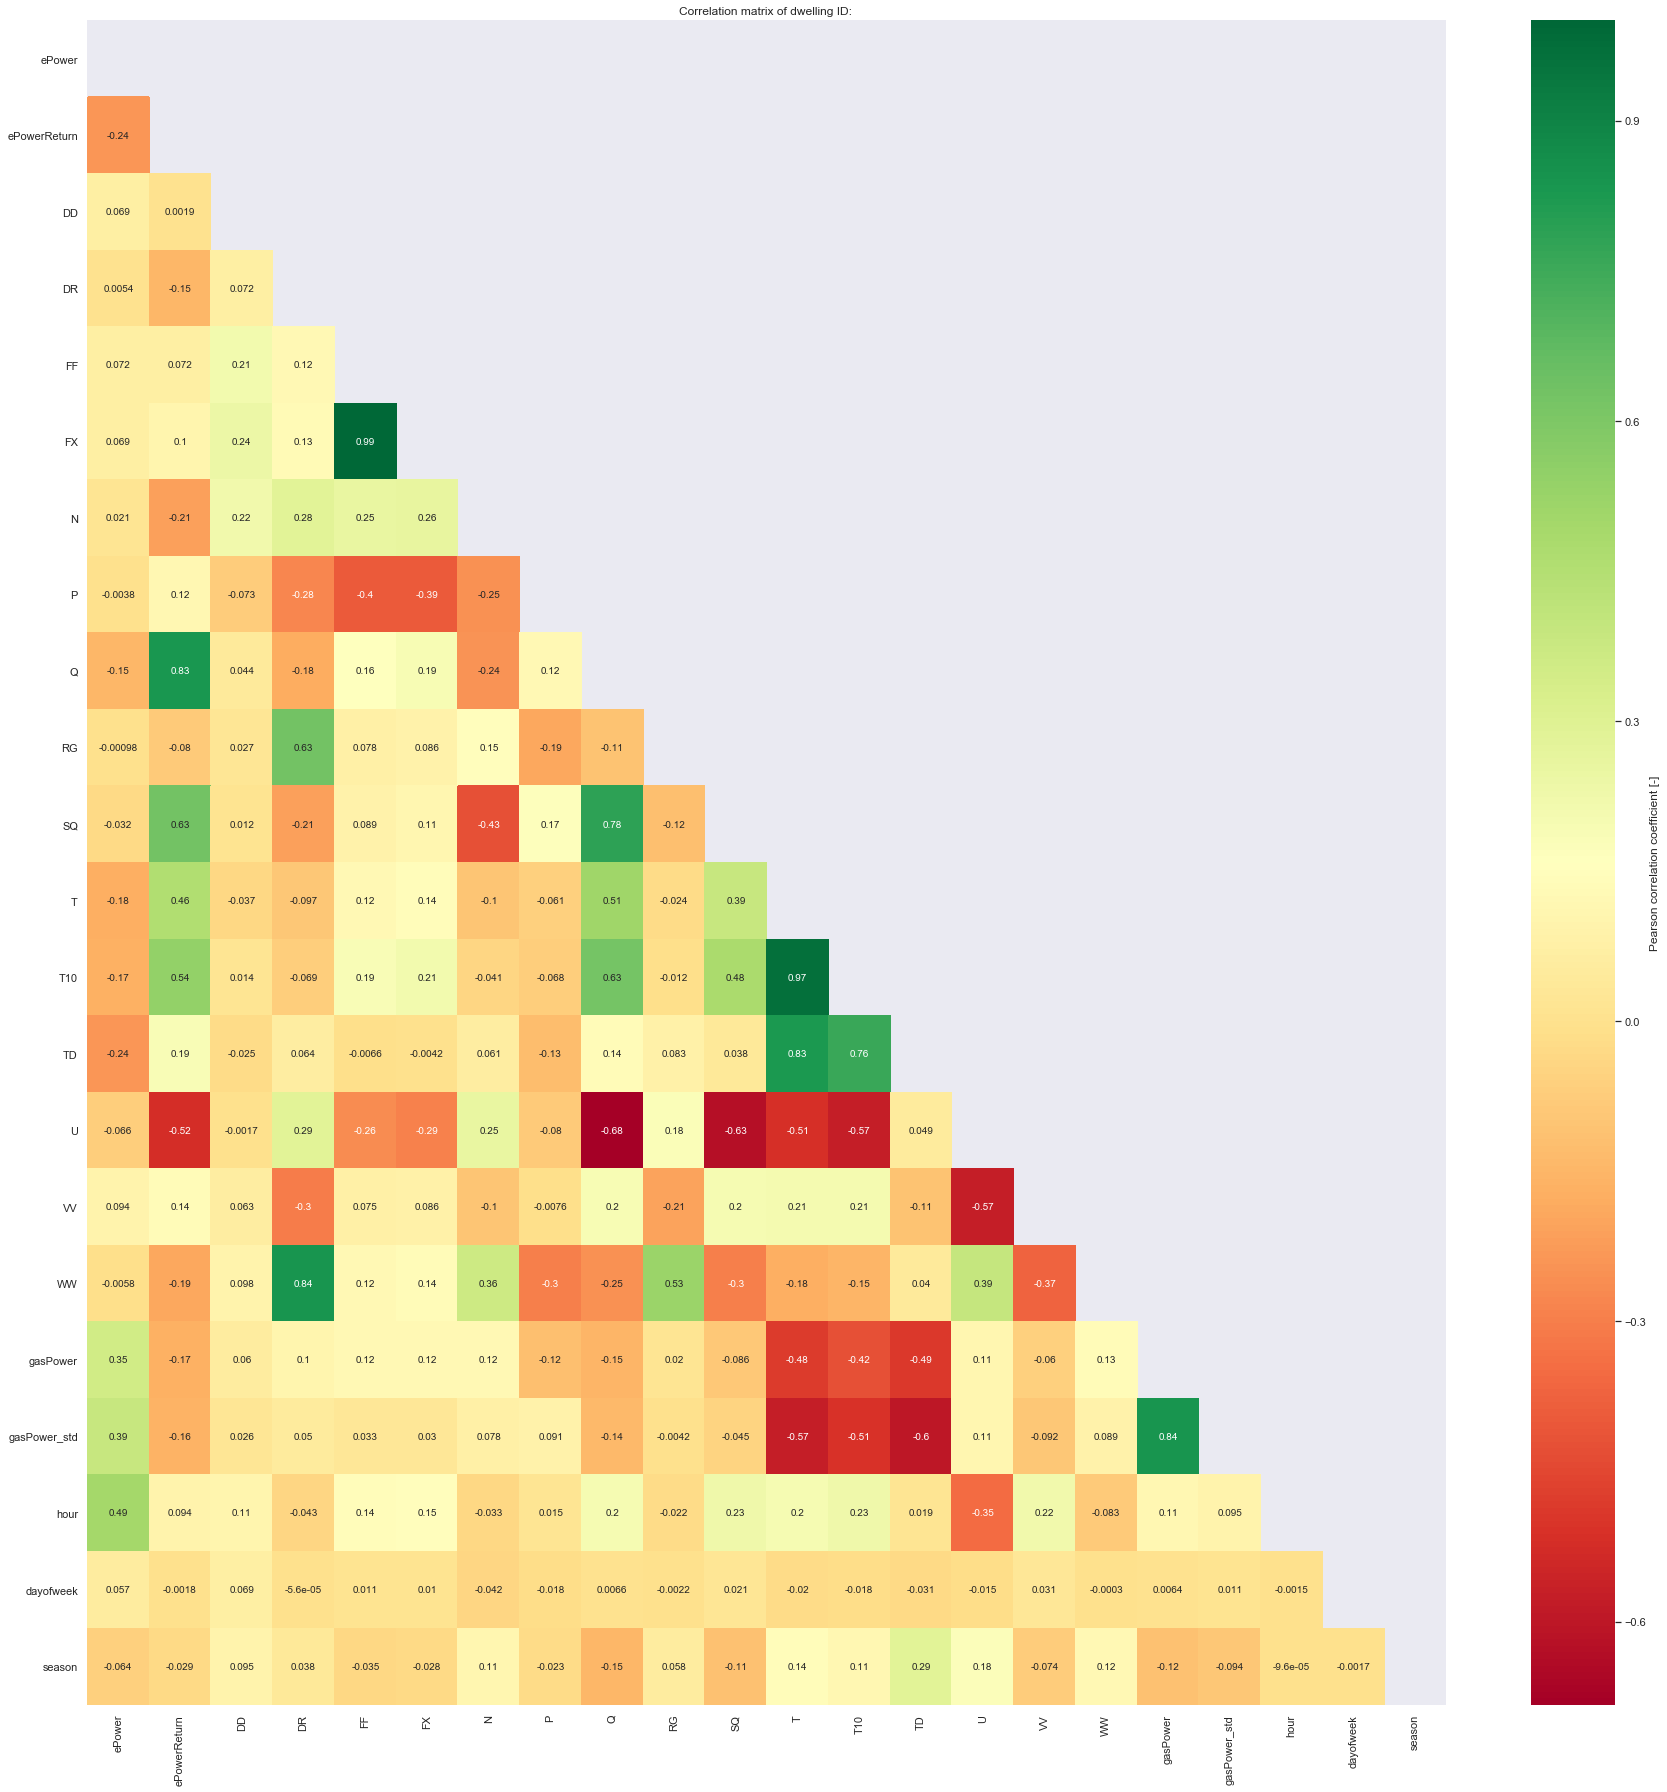

In [5]:
fig = create_corr_matrix(df, '', True)

# Select data to use

Saving heatmap
Len of data:  6352


<Figure size 432x288 with 0 Axes>

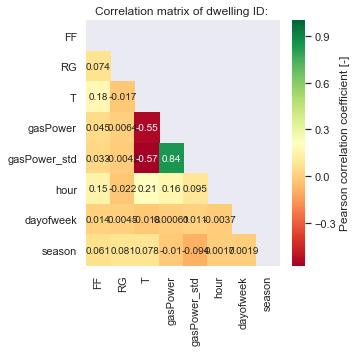

In [6]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

fig = create_corr_matrix(data, '', True, size=(5,5))

print('Len of data: ', len(data))

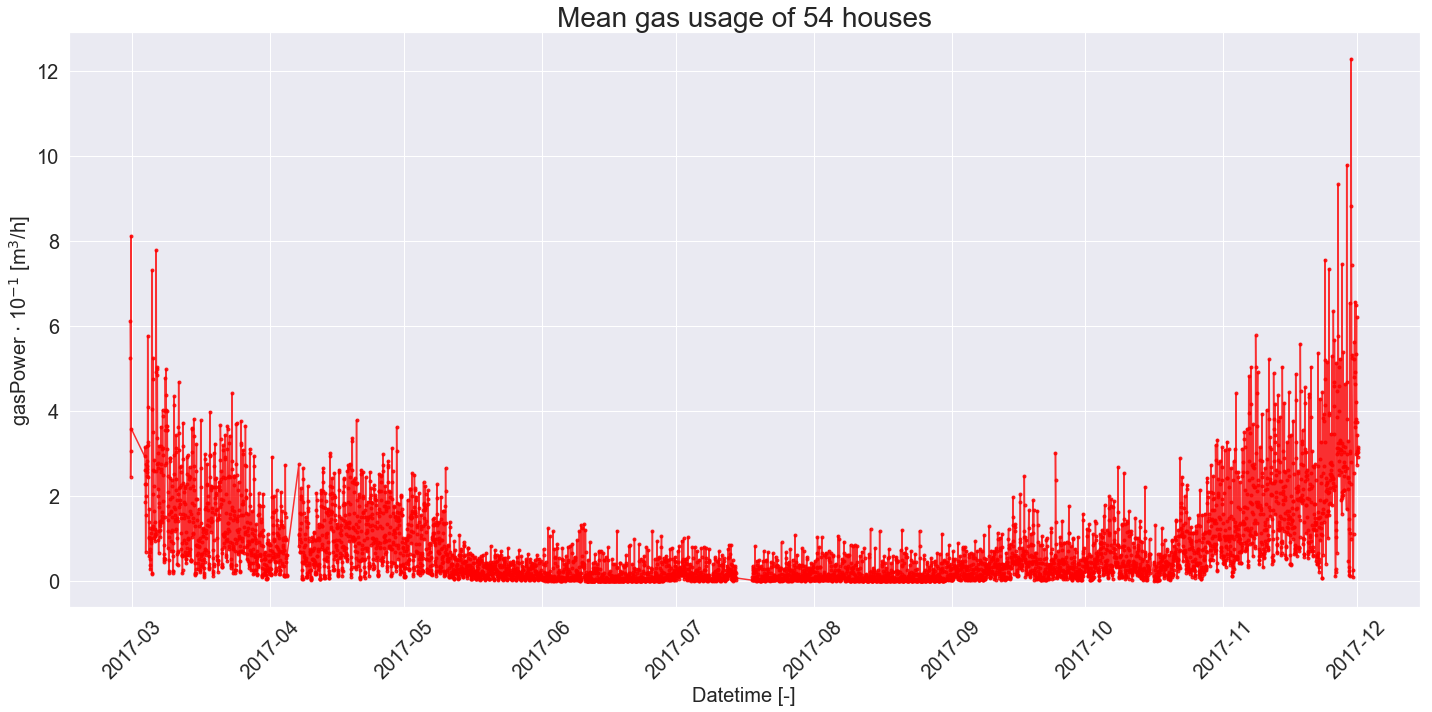

In [7]:
plt.figure(figsize=(20,10))

plt.plot(data.index, data['gasPower'], '.-', color='red', label='Original data', alpha=0.8)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % (magnitude), fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('Mean gas usage of 54 houses', fontsize=28)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

# Preprocessing

## datetime info to categorical

In [8]:
#columns_to_cat = ['year', 'month', 'day', 'hour', 'dayofweek', 'season']
columns_to_cat = ['hour', 'dayofweek', 'season']
data[columns_to_cat] = data[columns_to_cat].astype('category') # change datetypes to category

data = pd.get_dummies(data, columns=columns_to_cat) # One hot encoding the categories
data.head()

,FF,RG,T,gasPower,gasPower_std,hour_0,hour_1,hour_2,hour_3,hour_4,...,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_1,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-28 12:00:00,9.067500,0.0,5.183333,6.115723,0.085626,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 13:00:00,8.684999,0.0,5.300000,5.238647,0.318250,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 14:00:00,8.296667,0.0,5.283333,2.451172,0.041087,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 15:00:00,6.918334,0.0,5.516667,3.065186,0.214238,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 16:00:00,6.583333,0.0,5.433333,8.120117,0.014156,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


# Train test split and scale

In [9]:
from sklearn.model_selection import train_test_split
# Nobody turns on their heating when T > 19?, so deselect this data
#data = data[data['T'] < 19]

#X = filtered.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
X = data.drop(['gasPower'], axis=1)
print('X columns: %s' % list(X.columns))
y = data['gasPower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

test_size = 0.9

split_index = int(data.shape[0]*test_size) # the index at which to split df into train and test

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]
        
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

print((X_train.shape, y_train.shape))

print((X_test.shape, y_test.shape))

X columns: ['FF', 'RG', 'T', 'gasPower_std', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'season_1', 'season_2', 'season_3', 'season_4']
((5716, 39), (5716, 1))
((636, 39), (636, 1))


# Feedforward DNN model

In [10]:
def mape(y_true, y_pred):
    import keras.backend as K
    """
    Returns the mean absolute percentage error.
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

def smape(y_true, y_pred):
    import keras.backend as K
    """
    Returns the Symmetric mean absolute percentage error.
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))))*100

In [26]:
seed = 42

model = Sequential()

activation = 'relu'
#19
model.add(Dense(16, input_shape=(X_train.shape[1],), kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())
model.add(Dropout(0.5, seed=seed)) 

# Dropout: 1 wont ''drop'' any data, 0.5 will drop half of the data
# https://www.quora.com/How-does-the-dropout-method-work-in-deep-learning-And-why-is-it-claimed-to-be-an-effective-trick-to-improve-your-network
N = 256 #45

for i in range(4):
    model.add(Dense(N-i*4, kernel_initializer='TruncatedNormal'))
    model.add(LeakyReLU())
    model.add(Dropout(0.5, seed=seed))


model.add(Dense(1, kernel_initializer='TruncatedNormal'))
model.add(Activation('linear'))

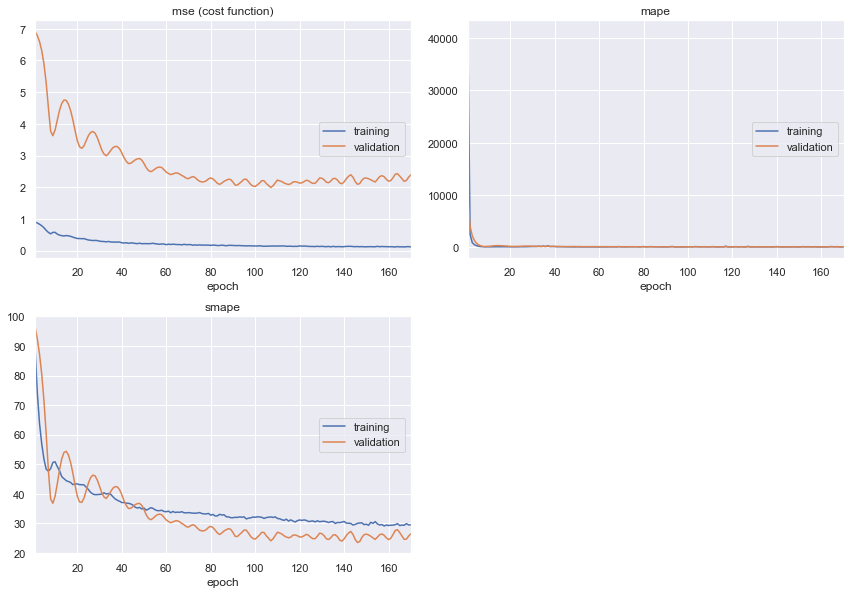

 - 0s - loss: 0.1147 - mape: 90.2601 - smape: 29.4725 - val_loss: 2.3906 - val_mape: 91.9423 - val_smape: 26.4269
CPU times: user 1min 23s, sys: 4.73 s, total: 1min 27s
Wall time: 1min 14s


In [27]:
%%time

model = multi_gpu_model(model, gpus=num_gpu)

lr = 0.55
epochs = 170 # Two times
decay_rate = 1*10**(-8)

sgd = SGD(lr=lr, momentum=0.9, decay=decay_rate, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower

# compiling the sequential model
model.compile(loss='mse', metrics=[mape, smape], optimizer='adam')

early_stopping_monitor = EarlyStopping(patience=5000)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
model.fit(X_train, y_train, batch_size=int(len(X_train)), epochs=epochs, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])

# Get prediction results

In [17]:
y_pred = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
print(len(y_true), len(x))

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

636 636


In [18]:
perc = (y_true - y_pred)/y_pred
perc.shape

(636, 1)

636/636 [==============================] - 0s 105us/step
FINISHED


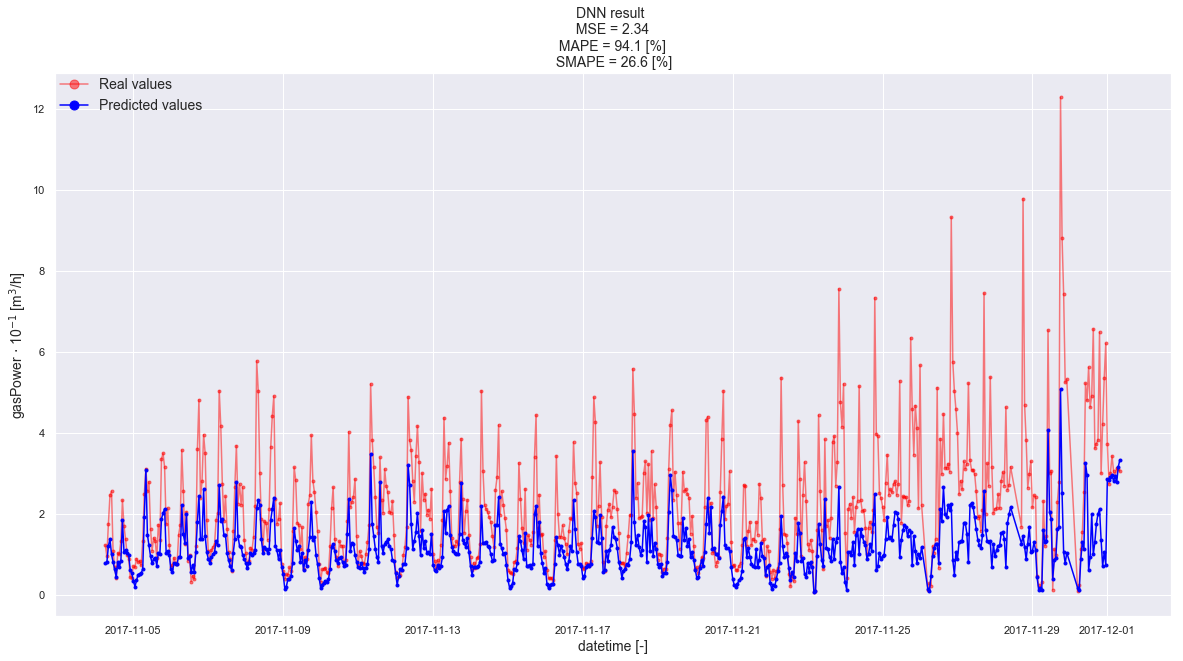

In [19]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result = model.evaluate(X_test, y_test)[0]
mape_result = model.evaluate(X_test, y_test)[1]
smape_result = model.evaluate(X_test, y_test)[2]

plt.title('DNN result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

# Downsample these results to a day

In [20]:
# Get results, put it in a dataframe

y_preds = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

# Make it a df to be able to downsample
datetime = x.index
print(datetime.shape)

y_preds = y_preds.reshape(y_preds.shape[0])
y_true = y_true.reshape(y_true.shape[0])

results = pd.DataFrame(y_true, y_preds) # For some reason y_true becomes the index
result = results.reset_index() # Ugly way to fix above problem
result.columns = ['y_pred', 'y_true']

result['datetime'] = datetime
result = result.set_index(['datetime'])


result.to_csv('model _results _data/DNN_predictions.csv')

result = result.resample('D').sum() # Resample data

result = result.dropna()

(636,)


In [21]:
# Calculate evaluation metrics over the result

ytrue = result['y_true']
ypred = result['y_pred']
n = len(result)

mse_result = (1/n)*np.sum((ypred - ytrue)**2)
mape_result = (100/n) * np.sum(np.abs((ytrue - ypred) / ypred))
smape_result = (100/n) * np.sum( np.abs((ytrue - ypred)) / (np.abs(ytrue) + np.abs(ypred)) )

Text(0.5, 1.0, 'DNN result \n MSE = 650.62 \n MAPE = 85.9 [%] \n SMAPE = 28.8 [%]')

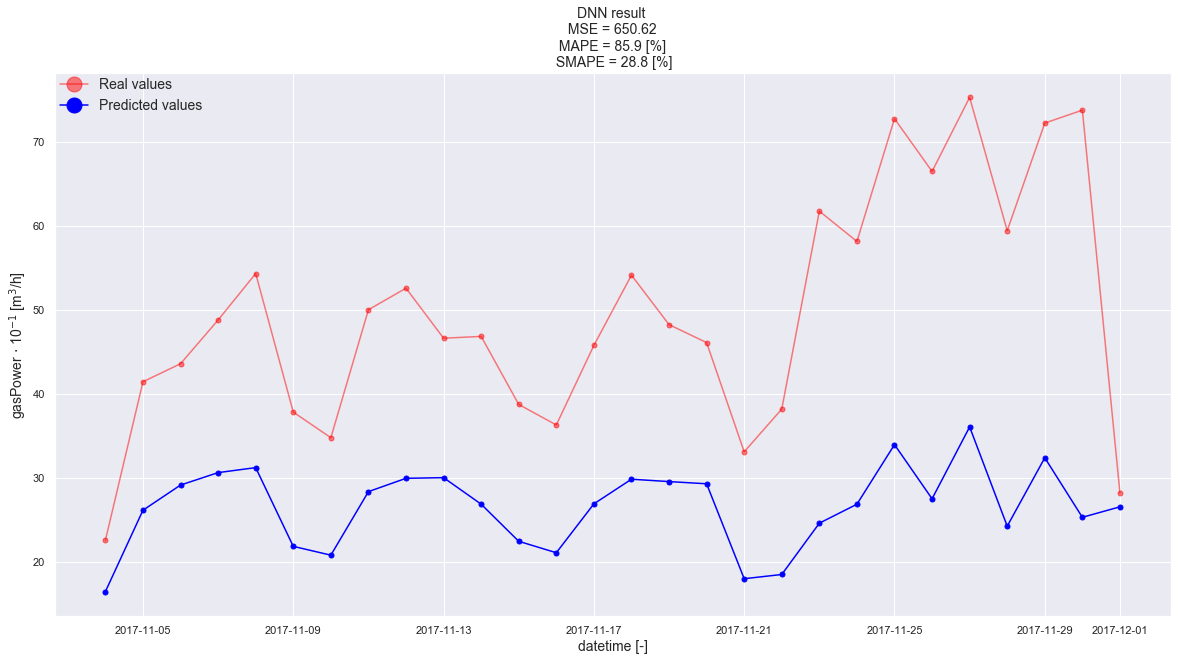

In [22]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot(result.index, result['y_true'], '.-', color='red', label='Real values', alpha=0.5, ms=10) # ms is markersize
plt.plot(result.index, result['y_pred'], '.-', color='blue', label='Predicted values', ms=10)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

plt.title('DNN result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/LSTM result hourly resampled to daily by sum.png', dpi=300)